In [1]:
# Essential libraries
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input, Lambda
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, SeparableConv2D, SpatialDropout2D
from tensorflow.keras.models import load_model
import plotly.graph_objs as go
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras.optimizers import Adam
#-------------------------------
import tensorflow as tf
from numpy.random import seed
seed(1)
tf.random.set_seed(1)
#-------------------------------

In [2]:
!pip install import-ipynb
import import_ipynb

In [3]:
from emotion_detection import EmotionDetection

importing Jupyter notebook from emotion_detection.ipynb


In [4]:
dataset_folder_name = "file_input/UTKFace"

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    },
    'age_id': {
        0: '0-24 yrs old',
        1: '25-49 yrs old',
        2: '50-74 yrs old',
        3: '75-99 yrs old',
        4: '100-124 yrs old'   
    }
}


dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id)
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id)
dataset_dict['age_alias'] = dict((r, i) for i, r in dataset_dict['age_id'].items())        # (Age: id)

In [5]:
class UtkFaceDataGenerator(EmotionDetection):
    '''
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model
    '''
    def parse_info_from_file(self, path):
        '''
        Parse information from a single file
        '''
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')
            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
    
    def parse_dataset(self, dataset_path, ext='jpg'):
        '''
        # Let's also define a function to help us on extracting the data from our dataset. This function will be
        # used to iterate over each file of the UTK dataset and return a Pandas Dataframe containing all the
        # fields (age, gender and race) of our records.
        Used to extract information about our dataset. It does iterate over all images and return a DataFrame
         with the data (age, gender and race) of all files.
        '''

        files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))

        '''
        records = []
        for file in files:
            info = parse_info_from_file(file)
            records.append(info)
        '''
        records = [self.parse_info_from_file(file)  for file in files]
        df = pd.DataFrame(records)
        df['file'] = files
        df.columns = ['age', 'gender', 'race', 'file']
        df = df.dropna()
        return df
    
    def generate_split_indexes(self, df):
        '''
        Data distribution for train and test
        '''
        p = np.random.permutation(len(df))
        train_up_to = int(len(df) * 0.8)      
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]
        ''' This basically makes 5 divisions in age-groups - 
                    0. 0-24
                    1. 25-49
                    2. 50-74
                    3. 75-99
                    4. 100-124 
        '''
        df['age'] = df['age']//25
        # converts alias to id
        df['gender_id'] = df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        df['race_id'] = df['race'].map(lambda race: dataset_dict['race_alias'][race])
        # Now we got train_idx, test_idx
        return train_idx, test_idx        

        
    def generate_images(self, df, image_idx, is_training, batch_size=16): 
        '''
        Used to generate a batch with images when training/testing/validating our Keras model
        '''
        # arrays to store our batched data
        images, ages, races, genders = [], [], [], []

        while True:
            for idx in image_idx:
                person = df.iloc[idx]

                age = person['age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['file']

                # Used to perform some minor preprocessing on the image before inputting into the network.
                im = Image.open(file)
                im = im.resize((198, 198))
                im = np.array(im) / 255.0

                races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                ages.append(to_categorical(age,5))
                images.append(im)

                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(genders), np.array(races)]
                    images, ages, genders, races = [], [], [], []

            if not is_training:
                break

    def  plot_train_history_loss(self,history,save_name):
        '''
        A function that displays the loss results of the model
        '''
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        axes[0].plot(history['race_output_loss'], label='Race Train loss')
        axes[0].plot(history['val_race_output_loss'], label='Race Val loss')
        axes[0].set_xlabel('Epochs')
        axes[0].legend()

        axes[1].plot(history['gender_output_loss'], label='Gender Train loss')
        axes[1].plot(history['val_gender_output_loss'], label='Gener Val loss')
        axes[1].set_xlabel('Epochs')
        axes[1].legend()

        axes[2].plot(history['age_output_loss'], label='Age Train loss')
        axes[2].plot(history['val_age_output_loss'], label='Age Val loss')
        axes[2].set_xlabel('Epochs')
        axes[2].legend()  

        axes[3].plot(history['loss'], label='Training loss')
        axes[3].plot(history['val_loss'], label='Validation loss')
        axes[3].set_xlabel('Epochs')
        axes[3].legend()
        plt.title(save_name)
        plt.savefig(save_name+'.png')
        
    def  plot_train_history_accuracy(self, history, save_name):
        '''
        A function that displays the accuracy results of the model
        '''
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].plot(history['race_output_accuracy'], label='Race Train accuracy')
        axes[0].plot(history['val_race_output_accuracy'], label='Race Val accuracy')
        axes[0].set_xlabel('Epochs')
        axes[0].legend()

        axes[1].plot(history['gender_output_accuracy'], label='Gender Train accuracy')
        axes[1].plot(history['val_gender_output_accuracy'], label='Gener Val accuracy')
        axes[1].set_xlabel('Epochs')
        axes[1].legend()

        axes[2].plot(history['age_output_accuracy'], label='Age Train accuracy')
        axes[2].plot(history['val_age_output_accuracy'], label='Age Val accuracy')
        axes[2].set_xlabel('Epochs')
        axes[2].legend()  
        plt.title(save_name)
        plt.savefig(save_name+'.png')
        
    def get_true_agr(self, df, test_idx):
        '''
        A function that returns images, age_true,gender_true, race_true
        '''
        test_generator = utkface_data_generator.generate_images(df, test_idx, is_training=False, batch_size=128)
        images, age_true,gender_true, race_true = [], [], [], []
        for test_batch in test_generator:    
            images.extend(test_batch[0])
            age_true.extend(test_batch[1][0])
            gender_true.extend(test_batch[1][1])
            race_true.extend(test_batch[1][2]) 
        return images, np.array(age_true), np.array(gender_true), np.array(race_true)
       
    def get_predict_agr(self, df, test_idx):
        '''
        A function that returns three variables of the model prediction: age_pred, gender_pred, race_pred
        '''
        test_generator = utkface_data_generator.generate_images(df, test_idx, is_training=False, batch_size=128)
        return model.predict(test_generator, steps=len(test_idx)//128)

In [6]:
utkface_data_generator =UtkFaceDataGenerator()
dataset_folder_name = "UTKFace"
df = utkface_data_generator.parse_dataset(dataset_folder_name)
df.head()

,age,gender,race,file
0,100,male,white,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg
1,100,male,white,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg
2,100,female,white,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg
3,100,female,white,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg
4,100,female,white,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg


### Data analysis & visualization (EDA)

After some data preprocessing, let's analyze the data using graphs to get a  better understanding about its distribution





In [7]:
df.info()       # No NAN values. Clean dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23708 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     23708 non-null  int64 
 1   gender  23708 non-null  object
 2   race    23708 non-null  object
 3   file    23708 non-null  object
dtypes: int64(1), object(3)
memory usage: 926.1+ KB


In [8]:
df.describe()
# Lower percentile - 25, median - 50 & upper percentile - 75 (for numerical data)

,age
count,23708.000000
mean,33.303484
std,19.886112
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


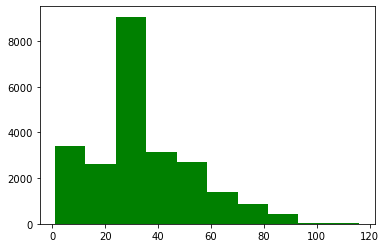

In [9]:
ages = df['age']
nbins = 10
plt.hist(ages,nbins,color='green',histtype='bar')
plt.show()

# Majority population lies between 20-30 age group. Clearly, the dataset is not very well balanced. So training will 
# not be easy & accurate. We don't want to be biased. Try using class weights ?

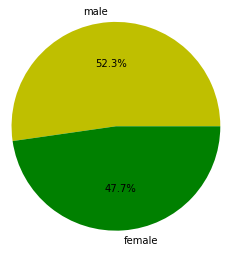

In [10]:
x = (df.gender=='male').sum()
y = (df.gender=='female').sum()
gender = [x,y]
labels = ['male','female']
colors = [ 'y', 'g'] 
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()

# Uniform distribution to a large extent. Although, males slightly exceed females in numbers.No need to change gender in data. 
# Pretty well balanced ! Lets also visualize this on a bar graph (to get better understanding of numbers)

,age
gender,
female,30.684280
male,35.695666


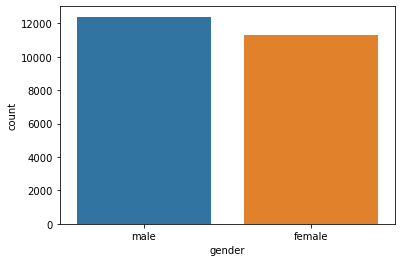

In [11]:
sns.countplot(x='gender', data=df);
df.groupby(['gender']).mean()             # Mean age by gender
# Males ~ Just over 12k
# Females ~ Just over 11k

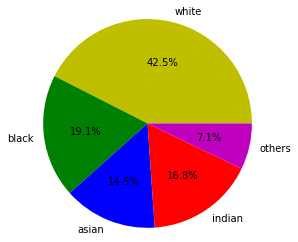

,age
race,
asian,25.867501
black,33.873482
indian,31.532830
others,23.169031
white,37.980949


In [12]:
x = (df.race=='white').sum()
y = (df.race=='black').sum()
z = (df.race=='asian').sum()
a = (df.race=='indian').sum()
b = (df.race=='others').sum()

gender = [x,y,z,a,b]
labels = ['white','black','asian','indian','others']
colors = [ 'y', 'g','b','r','m'] 
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()
df.groupby(['race']).mean()               # Mean age by race

,age
race,
asian,25.867501
black,33.873482
indian,31.532830
others,23.169031
white,37.980949


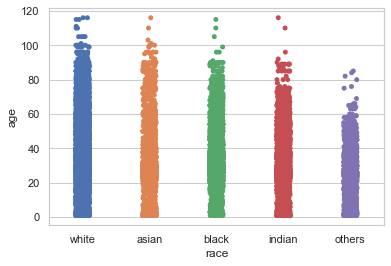

In [13]:
sns.set(style ="whitegrid") 
_ = sns.stripplot(x='race',y='age',data=df)
# Not very useful :( , we only understand that not many elderly ppl (above 60) in others category are present 
df.groupby(['race']).mean()               # Mean age by race

C:\anconda_update\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\anconda_update\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


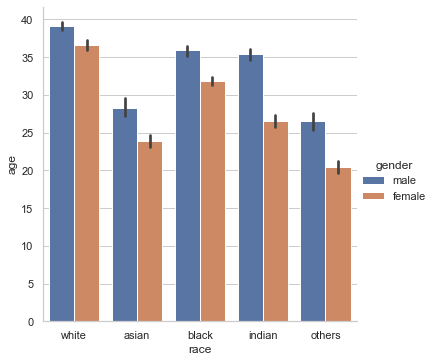

In [14]:
sns.factorplot('race', 'age', 'gender', data=df,kind='bar');

# Gives the mean age of both genders of all races

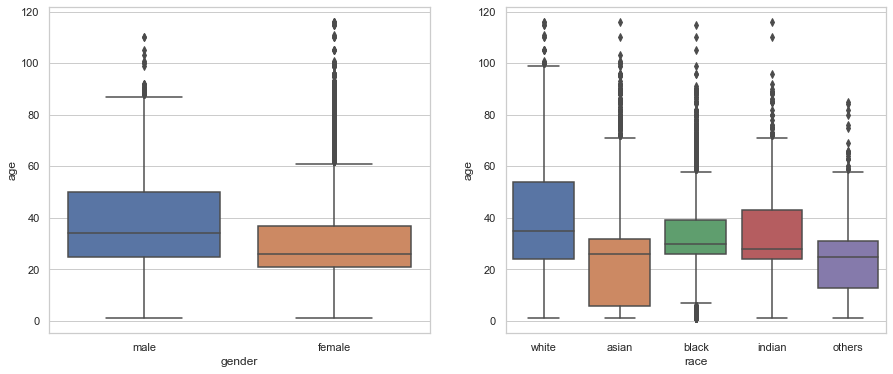

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

# We see that most of males are between 25 and 55, whereas most of the females are between 20 and 35
# Even while grouping by race, we find good amount of variations in different races

<AxesSubplot:xlabel='race,gender'>

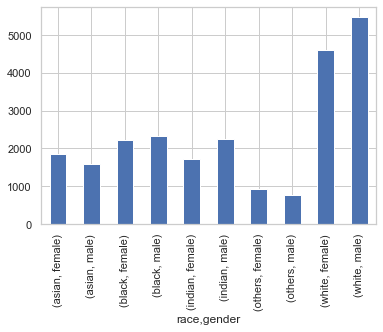

In [16]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

## Data Generator

In [17]:
train_idx, test_idx = utkface_data_generator.generate_split_indexes(df)

In [18]:
x = (df.age==0).sum()
y = (df.age==1).sum()
z = (df.age==2).sum()
a = (df.age==3).sum()
b = (df.age==4).sum()
print(x,' ',y,' ',z,' ',a,' ',b)


6903   11816   3990   967   32


In [19]:
df

,age,gender,race,file,gender_id,race_id
0,4,male,white,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,0,0
1,4,male,white,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,0,0
2,4,female,white,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,1,0
3,4,female,white,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,1,0
4,4,female,white,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,1,0
...,...,...,...,...,...,...
23703,0,female,indian,UTKFace\9_1_3_20161220222856346.jpg.chip.jpg,1,3
23704,0,female,indian,UTKFace\9_1_3_20170104222949455.jpg.chip.jpg,1,3
23705,0,female,others,UTKFace\9_1_4_20170103200637399.jpg.chip.jpg,1,4
23706,0,female,others,UTKFace\9_1_4_20170103200814791.jpg.chip.jpg,1,4


## Model Architecture

In [20]:
class UtkMultiOutputModel():
    '''
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    gender and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    '''
    def build_gender_branch(self, inputs):
        '''
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        '''
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)  

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(2)(x)
        x = Activation("sigmoid", name="gender_output")(x)      
        return x

    def build_race_branch(self, inputs):
        '''
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        '''
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)   

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(5)(x)
        x = Activation("softmax", name="race_output")(x) 
        return x

    def build_age_branch(self, inputs):   
        '''
        Used to build the age branch of our face recognition network.
        '''
        x = SeparableConv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = BatchNormalization(axis=-1)(x)

        x = SeparableConv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = BatchNormalization(axis=-1)(x)

        x = SeparableConv2D(256, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = SpatialDropout2D(0.1)(x)
        x = BatchNormalization(axis=-1)(x)

        x = SeparableConv2D(256, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = SpatialDropout2D(0.15)(x)
        x = BatchNormalization(axis=-1)(x)

        x = Flatten()(x)
        x = Dense(128, kernel_regularizer=l2(0.03))(x)
        x = Activation("relu")(x)
        x = Dropout(0.3)(x)
        x = BatchNormalization()(x)

        x = Dense(64)(x)
        x = Activation("relu")(x)
        x = Dropout(0.3)(x)
        x = BatchNormalization()(x)

        x = Dense(32)(x)
        x = Activation("relu")(x)
        x = Dropout(0.2)(x)
        x = BatchNormalization()(x)

        x = Dense(5)(x)
        x = Activation("softmax", name="age_output")(x)  

        return x


    def assemble_model(self):
        '''
        Used to assemble our multi-output model CNN.
        '''
        input_shape = (198, 198, 3)
        inputs = Input(shape=input_shape)

        age_branch = self.build_age_branch(inputs)
        gender_branch = self.build_gender_branch(inputs)
        race_branch = self.build_race_branch(inputs)
        model = Model(inputs=inputs, outputs = [age_branch, gender_branch, race_branch], name="face_net")
        return model
    

In [21]:
utkmulti_output_model = UtkMultiOutputModel()
model = utkmulti_output_model.assemble_model()

In [23]:
opt = Adam(lr=1e-4, decay=1e-4 / 100)
model.compile(optimizer=opt, 
              loss={
                  'age_output': 'categorical_crossentropy', 
                  'race_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy'},
              
              loss_weights={
                  'age_output': 4., 
                  'race_output': 1.5, 
                  'gender_output': 0.1},
              
              metrics={
                  'age_output': 'accuracy', 
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

C:\Users\ספיר\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [24]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(filepath='Age_gender_race_detection/best_model.h5', monitor='val_loss', save_best_only=True)]
train_gen = utkface_data_generator.generate_images(df, train_idx, is_training=True, batch_size=32)
valid_gen = utkface_data_generator.generate_images(df, test_idx, is_training=True, batch_size=32)

In [50]:
history = model.fit(train_gen, steps_per_epoch=len(train_idx)//32, epochs=100, callbacks= [callbacks],validation_data=valid_gen,validation_steps=len(test_idx)//32)

Epoch 1/100
592/592 [==============================] - 1289s 2s/step - loss: 16.2042 - age_output_loss: 1.6214 - gender_output_loss: 0.5898 - race_output_loss: 1.6588 - age_output_accuracy: 0.3517 - gender_output_accuracy: 0.7536 - race_output_accuracy: 0.4663 - val_loss: 15.5336 - val_age_output_loss: 1.3608 - val_gender_output_loss: 0.7188 - val_race_output_loss: 2.2737 - val_age_output_accuracy: 0.5087 - val_gender_output_accuracy: 0.7544 - val_race_output_accuracy: 0.4628
Epoch 2/100
592/592 [==============================] - 1296s 2s/step - loss: 12.7697 - age_output_loss: 1.2309 - gender_output_loss: 0.4421 - race_output_loss: 1.2105 - age_output_accuracy: 0.5239 - gender_output_accuracy: 0.8224 - race_output_accuracy: 0.5965 - val_loss: 11.0192 - val_age_output_loss: 0.9023 - val_gender_output_loss: 0.5360 - val_race_output_loss: 1.3302 - val_age_output_accuracy: 0.6767 - val_gender_output_accuracy: 0.8140 - val_race_output_accuracy: 0.5853
Epoch 3/100
592/592 [=================

### Save/ upload model

In [52]:
utkface_data_generator.save_model(history, model, 'History_agr_CNN', 'Model_agr_CNN')

INFO:tensorflow:Assets written to: Model_agr_CNN\assets


In [25]:
model, history=utkface_data_generator.load_models('Age_gender_race_detection/History_agr_CNN', 'Age_gender_race_detection/Model_agr_CNN')
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 198, 198, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 198, 198, 32) 155         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 198, 198, 32) 0           separable_conv2d[0][0]           
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 66, 66, 32)   0           activation[0][0]                 
___________________________________________________________________________________________

### Evaluation

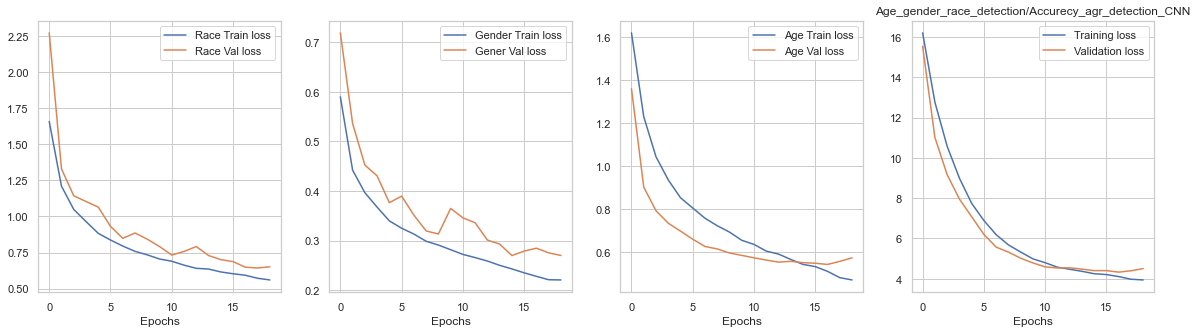

In [26]:
utkface_data_generator.plot_train_history_loss(history, 'Age_gender_race_detection/Accurecy_agr_detection_CNN')

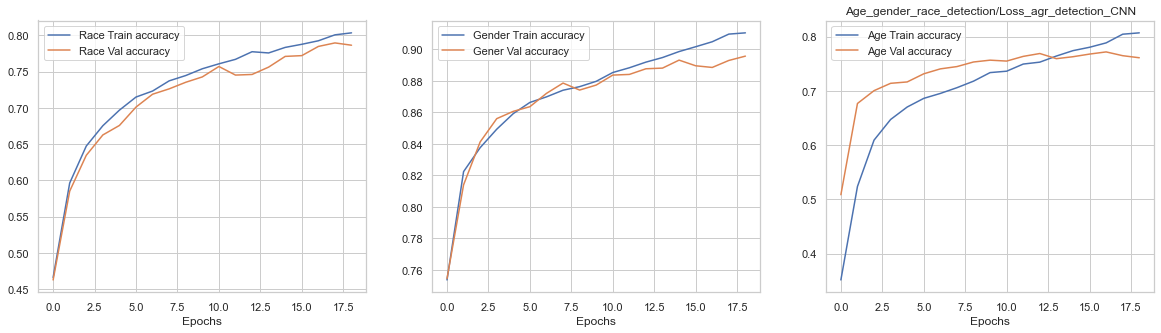

In [27]:
utkface_data_generator.plot_train_history_accuracy(history, 'Age_gender_race_detection/Loss_agr_detection_CNN')

In [28]:
images, age_true,gender_true, race_true = utkface_data_generator.get_true_agr(df, test_idx)

In [29]:
age_pred, gender_pred, race_pred = utkface_data_generator.get_predict_agr(df, test_idx)

              precision    recall  f1-score   support

       white       0.76      0.92      0.83      1984
       black       0.86      0.82      0.84       879
       asian       0.83      0.83      0.83       744
      indian       0.78      0.67      0.72       786
      others       0.49      0.06      0.11       343

    accuracy                           0.79      4736
   macro avg       0.74      0.66      0.67      4736
weighted avg       0.77      0.79      0.76      4736



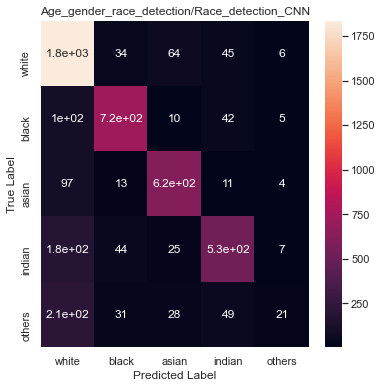

In [30]:
exp = list(dataset_dict['race_id'].values())
y_test_list, pred_list=utkface_data_generator.get_data_predict(race_pred, race_true)
report=utkface_data_generator.classification_report(y_test_list, pred_list, exp)
print(report)
utkface_data_generator.confusion_matrix(y_test_list, pred_list, exp, 'Age_gender_race_detection/Race_detection_CNN')

C:\anconda_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anconda_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anconda_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

   0-24 yrs old       0.82      0.71      0.76      1375
  25-49 yrs old       0.76      0.87      0.81      2411
  50-74 yrs old       0.68      0.61      0.64       763
  75-99 yrs old       0.79      0.37      0.51       179
100-124 yrs old       0.00      0.00      0.00         8

       accuracy                           0.76      4736
      macro avg       0.61      0.51      0.54      4736
   weighted avg       0.76      0.76      0.76      4736



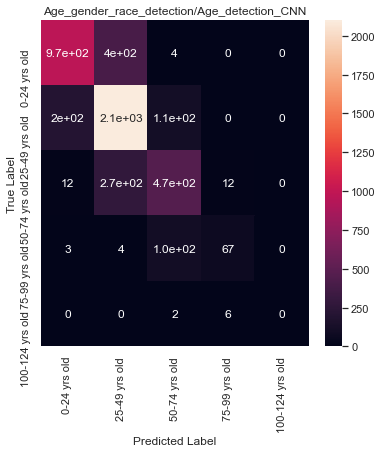

In [31]:
exp =  list(dataset_dict['age_id'].values())
y_test_list, pred_list=utkface_data_generator.get_data_predict(age_pred, age_true)
report=utkface_data_generator.classification_report(y_test_list, pred_list, exp)
print(report)
utkface_data_generator.confusion_matrix(y_test_list, pred_list, exp, 'Age_gender_race_detection/Age_detection_CNN')

              precision    recall  f1-score   support

        male       0.93      0.87      0.90      2443
      female       0.87      0.93      0.90      2293

    accuracy                           0.90      4736
   macro avg       0.90      0.90      0.90      4736
weighted avg       0.90      0.90      0.90      4736



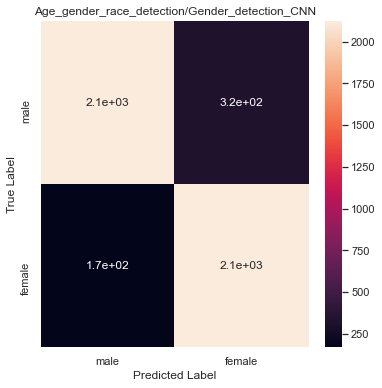

In [32]:
exp = list(dataset_dict['gender_id'].values())
y_test_list, pred_list=utkface_data_generator.get_data_predict(gender_pred, gender_true)
report=utkface_data_generator.classification_report(y_test_list, pred_list, exp)
print(report)
utkface_data_generator.confusion_matrix(y_test_list, pred_list, exp, 'Age_gender_race_detection/Gender_detection_CNN')